# 4.6.4 Quadratic Discriminant Analysis¶

Load modules and data

In [1]:
import pandas as pd
import numpy as np


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
from matplotlib import colors

Smarket = pd.read_csv('Data/Smarket.csv', usecols = range(1,10),parse_dates=True)

Load predefined functions

In [2]:
def plot_data(typ, X, y, y_pred, fig_index):
    splot = plt.subplot(1, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    alpha = 0.5

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', alpha=alpha,
             color='red')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '*', alpha=alpha,
             color='#990000')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', alpha=alpha,
             color='blue')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '*', alpha=alpha,
             color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = typ.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')
    
    #To make The Color difference visible
    
    Z[Z < 0.5] -= 0.3
    Z[Z > 0.5] += 0.3
    
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))

    return splot

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color, edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')

In [3]:
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

Now we will perform QDA on the Smarket data. In Python, we can fit a QDA model using the QuadraticDiscriminantAnalysis function, which is part of the sklearn library.

In [4]:
x_train = Smarket[0:sum(Smarket.Year<2005)][['Lag1','Lag2']]
y_train = Smarket[0:sum(Smarket.Year<2005)]['Direction']

qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train);

## Prior probabilities of groups:

In [5]:
print("Down: %f" % qda.priors_[0])
print("Up: %f" % qda.priors_[1])

Down: 0.491984
Up: 0.508016


The LDA output indicates prior probabilities of  π̂ 1=0.492π^1=0.492  and  π̂ 2=0.508π^2=0.508 ; in other words, 49.2% of the training observations correspond to days during which the market went down

## Group means:

In [6]:
pd.DataFrame(qda.means_,['Down', 'Up'],['Lag1','Lag2'])

,Lag1,Lag2
Down,0.042790,0.033894
Up,-0.039546,-0.031325


The output contains the group means. But it does not contain the coefficients of the linear discriminants, because the QDA classifier involves a quadratic, rather than a linear, function of the predictors.

The predict() function returns a list of QDA’s predictions about the movement of the market on the test data:

In [7]:
x_test = Smarket[sum(Smarket.Year<2005):][['Lag1','Lag2']] # Data from 2005
y_test = Smarket[sum(Smarket.Year<2005):]['Direction'] # Data from 2005
predict = qda.predict(x_test)
pd.DataFrame(confusion_matrix(y_test, predict).T,['Down', 'Up'],['Down','Up'])

,Down,Up
Down,30,20
Up,81,121


##### Correct Predictions and Test error rate

In [8]:
CP = (30+121.0)/(30+20+81+121)
Terr = 1-CP
print("Correct Predictions:") 
print(CP)
print("Test error rate:") 
print(Terr)

Correct Predictions:
0.599206349206
Test error rate:
0.400793650794


In [9]:
print(classification_report(y_test, predict, digits=3))

             precision    recall  f1-score   support

       Down      0.600     0.270     0.373       111
         Up      0.599     0.858     0.706       141

avg / total      0.599     0.599     0.559       252



Interestingly, the QDA predictions are accurate almost 60% of the time, even though the 2005 data was not used to fit the model. This level of accuracy is quite impressive for stock market data, which is known to be quite hard to model accurately. This suggests that the quadratic form assumed by QDA may capture the true relationship more accurately than the linear forms assumed by LDA and logistic regression. However, we recommend evaluating this method’s performance on a larger test set before betting that this approach will consistently beat the market!

## Performance comparison

E:\Programmer\Anaconda\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
E:\Programmer\Anaconda\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future
E:\Programmer\Anaconda\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
E:\Programmer\Anaconda\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


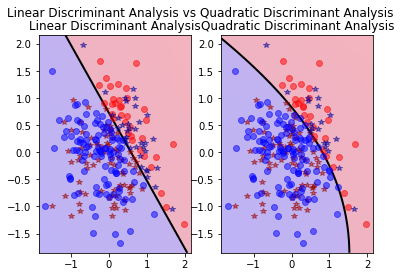

In [12]:
# With test Data
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver='svd', store_covariance=True)
y_LDA = lda.fit(x_train, y_train).predict(x_test)

# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariances=True)
y_QDA = qda.fit(x_train, y_train).predict(x_test)

x_test = x_test.values
y_test = y_test.values

y_test[y_test == 'Up'] = 1
y_test[y_test == 'Down'] = 0
y_test = y_test.astype(np.int)

y_LDA[y_LDA == 'Up'] = 1
y_LDA[y_LDA == 'Down'] = 0
y_LDA = y_LDA.astype(np.int)

y_QDA[y_QDA == 'Up'] = 1
y_QDA[y_QDA == 'Down'] = 0
y_QDA = y_QDA.astype(np.int)

splot = plot_data(lda, x_test, y_test, y_LDA, fig_index=1)
# plot_lda_cov(lda, splot)
plt.axis('tight')

splot = plot_data(qda, x_test, y_test, y_QDA, fig_index=2)
# plot_qda_cov(qda, splot)
plt.axis('tight')

plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis')
plt.show()